<a href="https://colab.research.google.com/github/vrhughes/DS4002-Project3/blob/main/SingleEpochVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing from example code
import os
from glob import glob
import tensorflow as tf
import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

In [ ]:
# Getting kaggle path
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intel-image-classification


In [ ]:
# Set image size and paths
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

# Classes you want to include
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea']

In [ ]:
# Checking what is in the folders we care about
for folder in os.listdir(train_dir):
  if folder in class_names:
    files = glob(pathname= str(train_dir + '/' + folder + '/*.jpg'))
    print(f'Found {len(files)} in folder {folder}')

Found 2512 in folder mountain
Found 2191 in folder buildings
Found 2274 in folder sea
Found 2271 in folder forest
Found 2404 in folder glacier


In [ ]:
# Data Augmentation and Normalization
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=20,
zoom_range=0.1,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.1,
horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load train and test data (excluding 'street')
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=IMAGE_SIZE,
batch_size=BATCH_SIZE,
classes=class_names,
class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=IMAGE_SIZE,
batch_size=BATCH_SIZE,
classes=class_names,
class_mode='categorical'
)

Found 11652 images belonging to 5 classes.
Found 2499 images belonging to 5 classes.


In [ ]:
# Load base VGG16 model (without top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False # Freeze base

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom layers
model = models.Sequential([
base_model,
layers.Flatten(),
layers.Dense(256, activation='relu'),
layers.Dropout(0.5),
layers.Dense(len(class_names), activation='softmax')
])

In [ ]:
# Compile the model
model.compile(
optimizer=optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['accuracy']
)

In [ ]:
# Train the model
history = model.fit(
train_generator,
epochs=1,
validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


365/365 ━━━━━━━━━━━━━━━━━━━━ 3680s 10s/step - accuracy: 0.7326 - loss: 0.7345 - val_accuracy: 0.8719 - val_loss: 0.3524


In [ ]:
# printing accuracy and loss
ModelLoss, ModelAccuracy = model.evaluate(test_generator)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

79/79 ━━━━━━━━━━━━━━━━━━━━ 633s 8s/step - accuracy: 0.8684 - loss: 0.3527
Test Loss is 0.35243159532546997
Test Accuracy is 0.871948778629303


In [ ]:
# Saving the model
model.save("vgg16_model_1epoch.h5", include_optimizer = True)

In [ ]:
model.save('vgg16_1epoch_keras.keras')

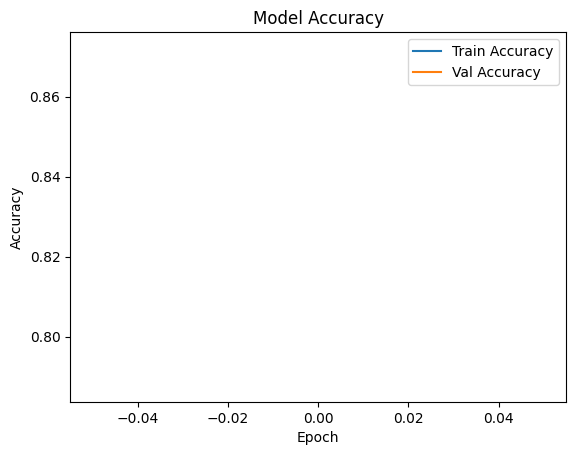

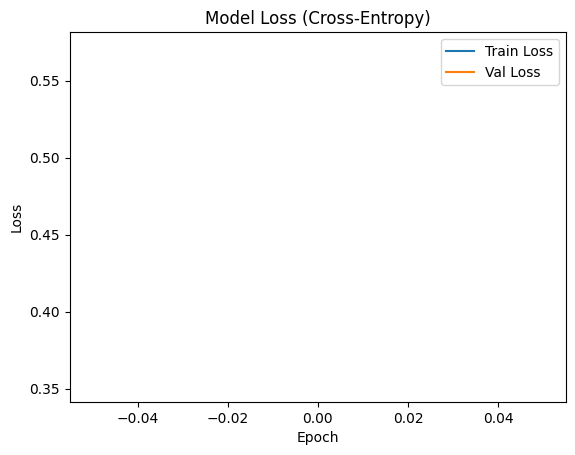

In [ ]:
# Plotting accuracy and loss over the course of training
import matplotlib.pyplot as plt


# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (Cross-Entropy)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get true labels and predictions
Y_predictions = model.predict(test_generator)
y_pred = np.argmax(Y_predictions, axis=1)

# True labels
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(classification_report(true_labels, y_pred, target_names=class_labels))

79/79 ━━━━━━━━━━━━━━━━━━━━ 647s 8s/step
              precision    recall  f1-score   support

   buildings       0.16      0.16      0.16       437
      forest       0.18      0.18      0.18       474
     glacier       0.24      0.24      0.24       553
    mountain       0.20      0.19      0.19       525
         sea       0.23      0.25      0.23       510

    accuracy                           0.20      2499
   macro avg       0.20      0.20      0.20      2499
weighted avg       0.20      0.20      0.20      2499



<Axes: >

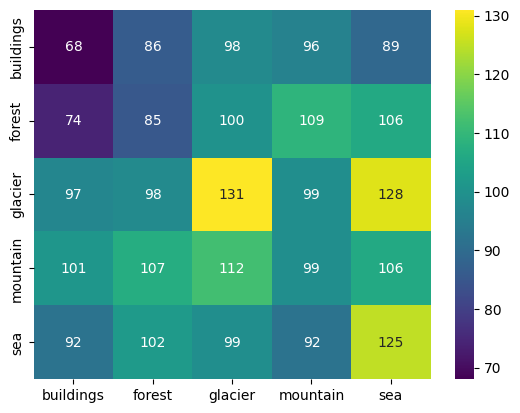

In [ ]:
# Prediction heat map
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
sns.heatmap(confusion_matrix(true_labels, y_pred),
            annot=True,
            fmt='.3g',
            xticklabels = class_labels,
            yticklabels = class_labels,
            cmap='viridis')